# 04. PyTorch Custom Datasets

How do you get your own data into PyTorch

One of the ways to do so is via: custom datasets

## Domain libraries
Depending on what you are working on, vision, text, audio, recommendation, you want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.

In [ ]:
## 0. Importing PyTorch and setting up device-agnostic code
import torch
from torch import nn

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## 1. Get data

Our dataset is a subset of the Food101 dataset.

Food101 starts with 101 different classes of food and 1000 images per class (750 training, 250 testing)

Our dataset starts with 3 classes of food and only 10% of the images (75 training, 25 testing)

In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

# If the image folder doesn't exist, download it
if image_path.is_dir():
  print(f"Image directory already exist....skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download image data
with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
  request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
  print(f"Downloading pizza, steak, sushi zip")
  f.write(request.content)

# Unzip the data
with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
  print(f"Unzipping the folder...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist, creating one...
Unzipping the folder...


## 2. Becoming one with the data (data preparation and data exploration)

In [ ]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents"""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza


In [ ]:
# Setup train and testing paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

### 2.1 Visualizing the image

1. Get all image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Open the image with Python's PIL
5. Show the image and print metadata

Random image path: data/pizza_steak_sushi/test/pizza/648055.jpg
Image class: pizza
Image height: 512
Image width: 512


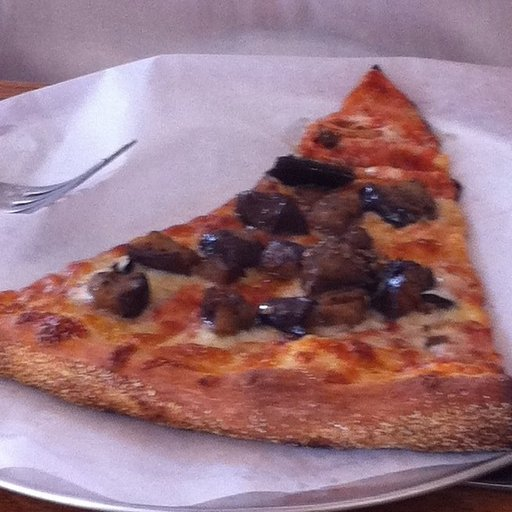

In [ ]:
import random
from PIL import Image

random.seed(42)

# Get all image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))

# Pick a random image path
random_image_path = random.choice(image_path_list)

# Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# Open image
img = Image.open(random_image_path)

# Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

Text(0.5, 1.0, 'Image class: pizza | Image shape: (512, 512, 3) -> [height, width, color channels]')

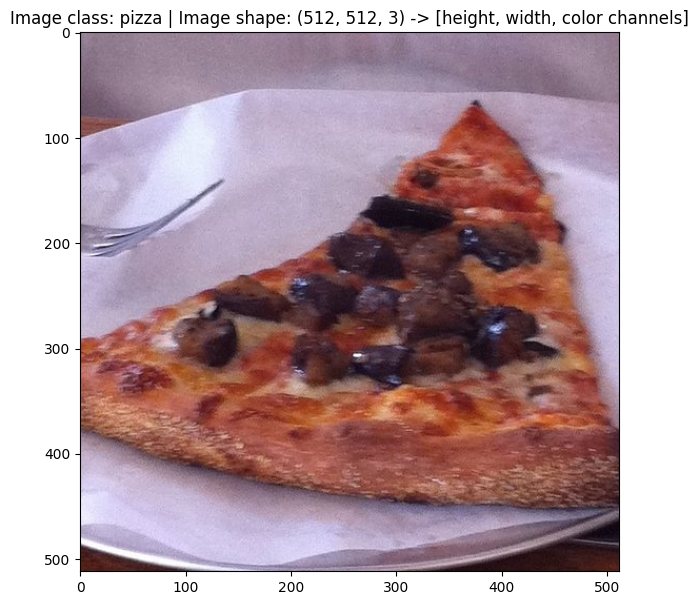

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color channels]")

## 3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (numerical representation of our images)
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we will call these `Dataset` and `DataLoader`

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

In [ ]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our image to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # 'p=0.5' means 50% of images going through this transform pipeline, it will get flip on horizontal axis
    # Turn the image into torch.tensor
    transforms.ToTensor()
])

In [ ]:
data_transform(img).shape

torch.Size([3, 64, 64])

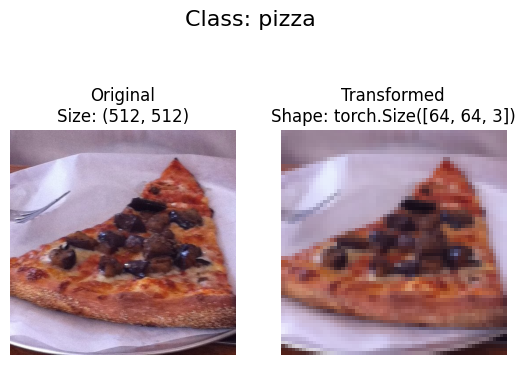

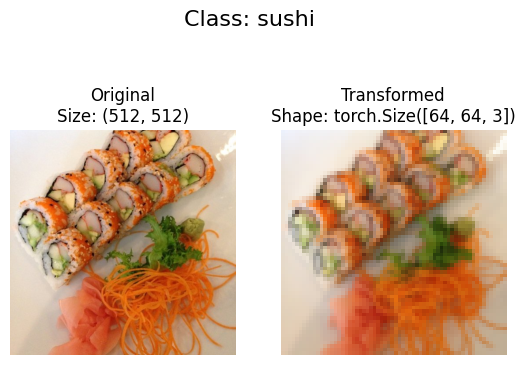

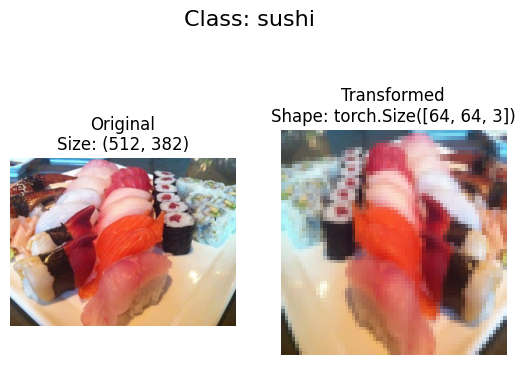

In [ ]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):

  """Selects random images from a path of images and loads/transforms them,
     then plots the original vs the transformed version"""

  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib, in this case we swapped index positions, 'permute(1, 2, 0)' means index 1 goes to 0, index 2 goes to 1, and index 0 ges to 2, (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list, transform=data_transform, seed=42)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`

In [ ]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

In [ ]:
# Get class names as list
class_names = train_data.classes

In [ ]:
# Get class names as dict
class_dict = train_data.class_to_idx

In [ ]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Text(0.5, 1.0, 'pizza')

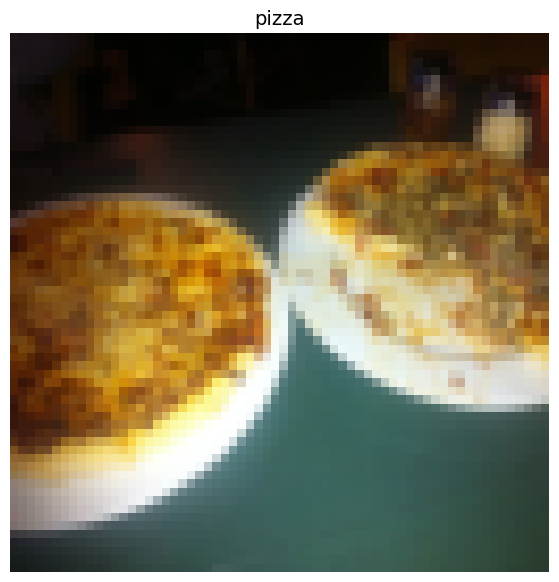

In [ ]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis('off')
plt.title(class_names[label], fontsize=14)

## 4.1 Turn loaded images into `DataLoader`'s

A `DataLoader` is going to help us turn our `Dataset`'s into iterables and we can customized the `batch_size` so our model can see `batch_size` images at a time

In [ ]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader

batch_size =32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=batch_size,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=batch_size,
                             num_workers=os.cpu_count(),
                             shuffle=False)

## 5 Option 2: Loading Image Data with a Custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dict from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it doesn't mean it will work...
* Using a custom `Dataset` often results in more codes

In [ ]:
import os
import pathlib

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [ ]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

In [ ]:
# Setup path for target directory
target_directory = train_dir

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

['pizza', 'steak', 'sushi']

In [ ]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory"""
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}, please check file structure.")

  # 3. Create a dict of index labels ()
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

All custom datasets in PyTorch, often subclass `torch.utils.data.Dataset`

To create our own custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we would like to get data from) as well as a transform if we would like to transform our data
3. Create several attributes:
  * paths - paths of our images
  * transform - the transform we would like to use
  * classes - a list of the target classes
  * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an index


In [ ]:
# Write a custom dataset class
from torch.utils.data import Dataset

# Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # Init our custom dataset
  def __init__(self, targ_dir: str, transform=None):
    # Create class attributes
    # Get all of the image paths
    self.paths = list(pathlib.Path(targ_dir).glob('*/*.jpg'))
    # Setup transforms
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # Create a function to load images
  def load_images(self, index: int) -> Image.Image:
    """Opens an image via a path and returns it"""
    image_path = self.paths[index]
    return Image.open(image_path)

  # Overwrite __len__()
  def __len__(self) -> int:
    """Returns the total number of samples"""
    return len(self.paths)

  # Overwrite __getitem__() method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    """Returns one sample of data, data and label (x, y)"""
    img = self.load_images(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label (x, y)
    else:
      return img, class_idx # return untransformed image and label

In [ ]:
# Create a transform
train_transforms = transforms.Compose([transforms.Resize(size=(64, 64)),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.ToTensor()
                                      ])
test_transforms = transforms.Compose([transforms.Resize(size=(64, 64)),
                                      transforms.ToTensor()
                                     ])

In [ ]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to display
2. Cap the number of images to display at 10
3. Get a list of random sample indexes from the target dataset
4. Loop through the random sample images and plot them with matplotlib
5. Make sure the dimensions of our images line up with matplotlib (HWC)


In [ ]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display, it shouldn't be larger than 10, setting to 10 and removing shape display.")

  # Set the seed
  if seed:
    random.seed(seed)

  # Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # Setup plot
  plt.figure(figsize=(16, 8))

  # Loop through random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]


    # Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0) # [c, h, w] -> [h, w, c]

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis('off')
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)


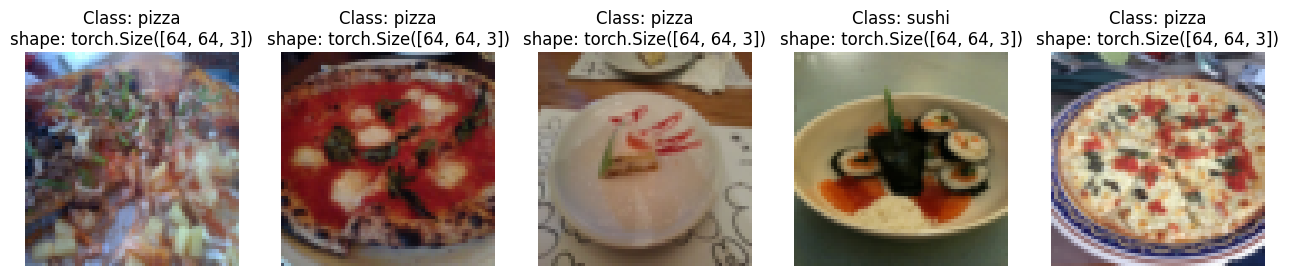

In [ ]:
# Display random images from the ImageFolder created Dataset
display_random_images(dataset=train_data, n=5, classes=class_names, seed=None)

For display, it shouldn't be larger than 10, setting to 10 and removing shape display.


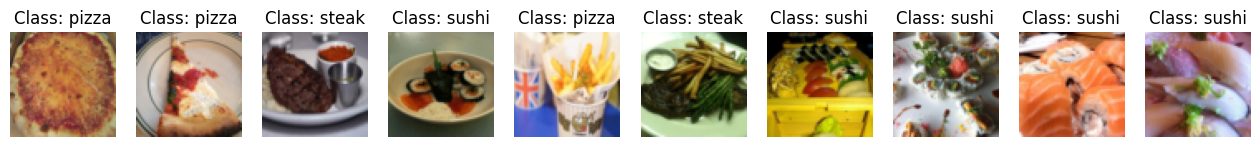

In [ ]:
# Display random images from the ImageFolderCustom Dataset
display_random_images(dataset=train_data_custom, n=11, classes=class_names, seed=None)

### 5.4 Turn custom loaded images into `DataLoader`

In [ ]:
from torch.utils.data import DataLoader

batch_size = 32
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=batch_size,
                                     num_workers=os.cpu_count(),
                                     shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=batch_size,
                                    num_workers=os.cpu_count(),
                                    shuffle=True)

In [ ]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transforms (data augmentation)

Data augmentation is the process of artificially adding diversity to your training data

In the case of image data, this may mean applying various image transformations to the training images

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels

This practice hopefully results in a model that's more generalizable to unseen data

In [ ]:
# Let's look at trivailaugment
from torchvision import transforms

train_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                      transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                      transforms.ToTensor()
                                     ])

test_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor()
                                    ])

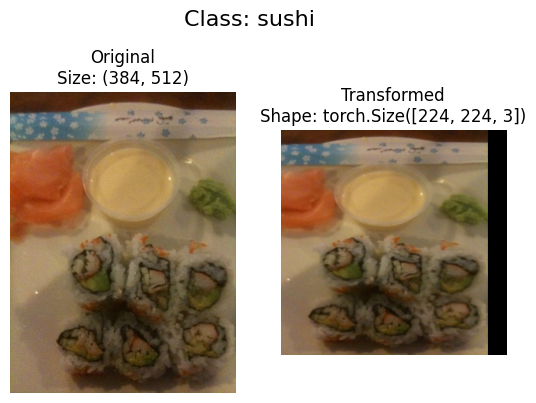

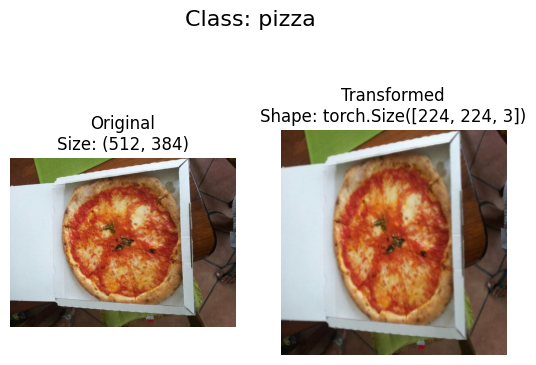

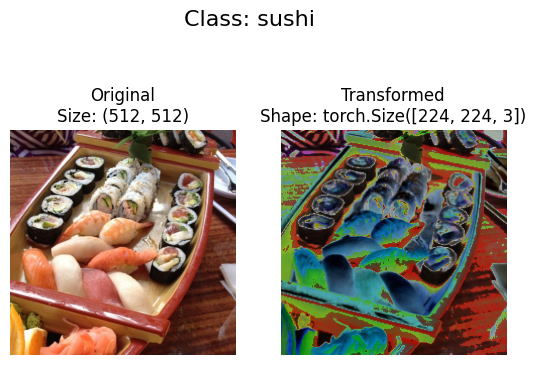

In [ ]:
# Get all image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))

# Plot random transformed images
plot_transformed_images(image_paths=image_path_list,
                        transform=train_transform,
                        n=3,
                        seed=None)

## 7. Model 0: TinyVGG without data augmentation

### 7.1 Creating transforms and loading data for Model 0

In [ ]:
# Create simple transform
simple_transform = transforms.Compose([transforms.Resize(size=(64, 64)),
                                       transforms.ToTensor()
                                      ])

In [ ]:
# Load and transform data
from torchvision import datasets

train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
batch_size = 32
num_workers = os.cpu_count()

# Create DataLoader
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=batch_size,
                                     shuffle=True,
                                     num_workers=num_workers)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=batch_size,
                                    shuffle=False,
                                    num_workers=num_workers)

### 7.2 Create TinyVGG model class

In [ ]:
from torch.nn.modules.activation import ReLU
class TinyVGG(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) # default stride value is same as kernel_size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) # default stride value is same as kernel_size
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13, out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x
    # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # this will return the same thing, benefits from operation fusion

In [ ]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)


### 7.3 Try a forward pass on a single image (to test the model)

In [ ]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))

# Try a forward pass
model_0(image_batch)

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9131e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [ ]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Create train and test loops functions

* `train_step()` - takes in a model and dataloader and trains the model on the dataloader
* `test_step()` - same process, takes in a model and dataloader, evaluates the model on the dataloader

In [ ]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):

  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through dataloader data batches
  for batch, (x, y) in enumerate(dataloader):
    x, y = x.to(device), y.to(device)

    # Forward pass
    y_pred = model(x)

    # Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Optimizer step
    optimizer.step()

    # Calculate the accuracy
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc


In [ ]:
# Create test_step()
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):

  model.eval()
  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    # Loop through dataloader data batches
    for batch, (x, y) in enumerate(dataloader):
      x, y = x.to(device), y.to(device)

      test_pred = model(x)

      loss = loss_fn(test_pred, y)
      test_loss += loss.item() # .item just give you the integer

      test_pred_class = torch.argmax(torch.softmax(test_pred, dim=1), dim=1)
      # test_pred_class = test_pred.argmax(dim=1) # this would works the same as the line above
      test_acc += (test_pred_class==y).sum().item()/len(test_pred)

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)

  return test_loss, test_acc

### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`



In [ ]:
from tqdm.auto import tqdm

# Create a train function that takes in various model parameters
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):

  # Create empty results dict
  results = {'train_loss': [],
             'train_acc': [],
             'test_loss': [],
             'test_acc': []
            }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)

    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}% | Test loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

    # Update results dict
    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

### 7.7 Train and evaluate model_0

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

num_epochs = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=num_epochs,
                        device=device)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1063 | Train Acc: 0.3047% | Test loss: 1.0983 | Test Acc: 0.3011
Epoch: 1 | Train loss: 1.0998 | Train Acc: 0.3281% | Test loss: 1.0697 | Test Acc: 0.5417
Epoch: 2 | Train loss: 1.0868 | Train Acc: 0.4883% | Test loss: 1.0807 | Test Acc: 0.4924
Epoch: 3 | Train loss: 1.0843 | Train Acc: 0.4023% | Test loss: 1.0608 | Test Acc: 0.5833
Epoch: 4 | Train loss: 1.0662 | Train Acc: 0.4102% | Test loss: 1.0656 | Test Acc: 0.5644
Total training time: 15.072 seconds


### 7.8 Plot the loss curves of Model_0

A **loss curve** is a way of tracking your model's progress over time

In [ ]:
# Get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a results dict"""

  # Get the loss values of the results dict
  loss = results['train_loss']
  test_loss = results['test_loss']

  accuracy = results['train_acc']
  test_accuracy = results['test_acc']

  # Find how many epochs were there
  epochs = range(len(results['train_loss']))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label='train_loss')
  plt.plot(epochs, test_loss, label='test_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label='train_accuracy')
  plt.plot(epochs, test_accuracy, label='test_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()


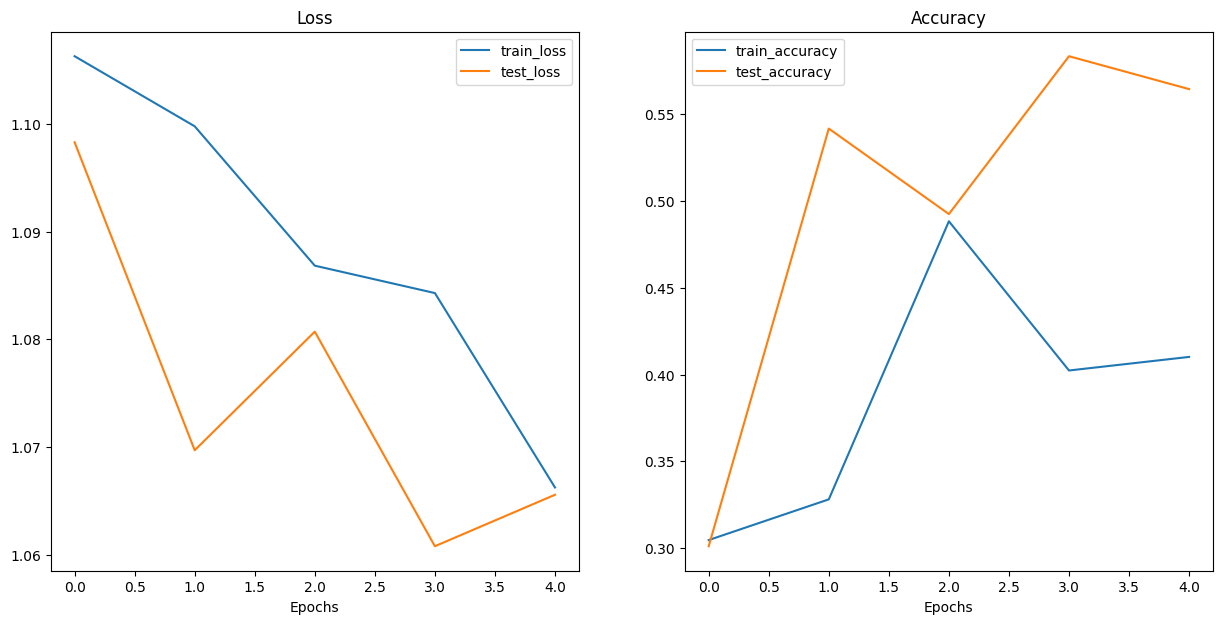

In [ ]:
plot_loss_curves(model_0_results)

## 8. What should an ideal loss curve look like

A loss curve is one of the most helpful ways to troubleshoot a model

https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

## 9. Model 1: TinyVGG with data augmentation

Let's try another modelling experiment, this time using the same model model_0 with some data augmentation

### 9.1 Create transform with data augmentations

In [ ]:
# Create training transform with TrivialAugment
from torchvision import transforms

train_transform_trivial = transforms.Compose([transforms.Resize(size=(64, 64)),
                                              transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                              transforms.ToTensor()
                                            ])


test_transform_simple = transforms.Compose([transforms.Resize(size=(64, 64)), transforms.ToTensor()])


### 9.2 Create train and test `Dataset` and `DataLoader` with data augmentation

In [ ]:
# Turn image folders into Datasets
from torchvision import datasets

train_data_augmented = datasets.ImageFolder(root=train_dir, transform=train_transform_trivial)

test_data_simple = datasets.ImageFolder(root=test_dir, transform=test_transform_simple)

In [ ]:
# Turn Datasets into DataLoaders
import os
batch_size = 32
num_workers = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented, batch_size=batch_size, shuffle=True, num_workers=num_workers)

test_dataloader_simple = DataLoader(dataset=test_data_simple, batch_size=batch_size, shuffle=False, num_workers=num_workers)


### 9.3 Construct and train model 1

We will be using the same model architecture except this time we have augmented the training data

In [ ]:
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(train_data_augmented.classes)).to(device)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

num_epochs = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=num_epochs,
                        device=device)

end_time = timer()
print(f"Total training time for model_1: {end_time-start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1049 | Train Acc: 0.2500% | Test loss: 1.1019 | Test Acc: 0.2604
Epoch: 1 | Train loss: 1.0807 | Train Acc: 0.4258% | Test loss: 1.1261 | Test Acc: 0.2604
Epoch: 2 | Train loss: 1.0712 | Train Acc: 0.4258% | Test loss: 1.1593 | Test Acc: 0.2604
Epoch: 3 | Train loss: 1.1253 | Train Acc: 0.3047% | Test loss: 1.1581 | Test Acc: 0.2604
Epoch: 4 | Train loss: 1.0864 | Train Acc: 0.4258% | Test loss: 1.1555 | Test Acc: 0.3333
Total training time for model_1: 16.793 seconds


### 9.4 Plot the loss curves of model_1

A loss curve helps you evaluate your models performance overtime

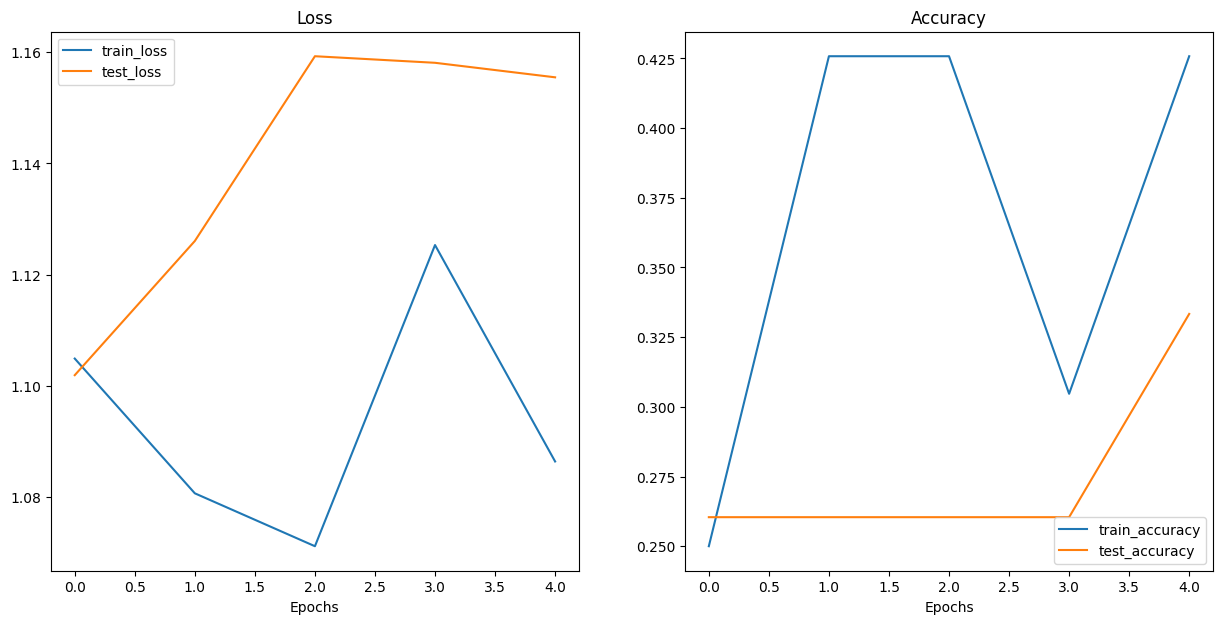

In [ ]:
plot_loss_curves(model_1_results)

## 10. Compare model results

It is important to compare models to each other for its performances, plot them against each other

There are options on how to do this:
1. Hard coding the plots (what we have been doing throughout the training)
2. PyTorch + Tensorboard  
3. Weights & Biases https://wandb.ai/site
4. MLFlow https://mlflow.org/



In [ ]:
import pandas as pd

model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106319,0.304688,1.098321,0.301136
1,1.099805,0.328125,1.069692,0.541667
2,1.086849,0.488281,1.080716,0.492424
3,1.084303,0.402344,1.060770,0.583333
4,1.066231,0.410156,1.065553,0.564394


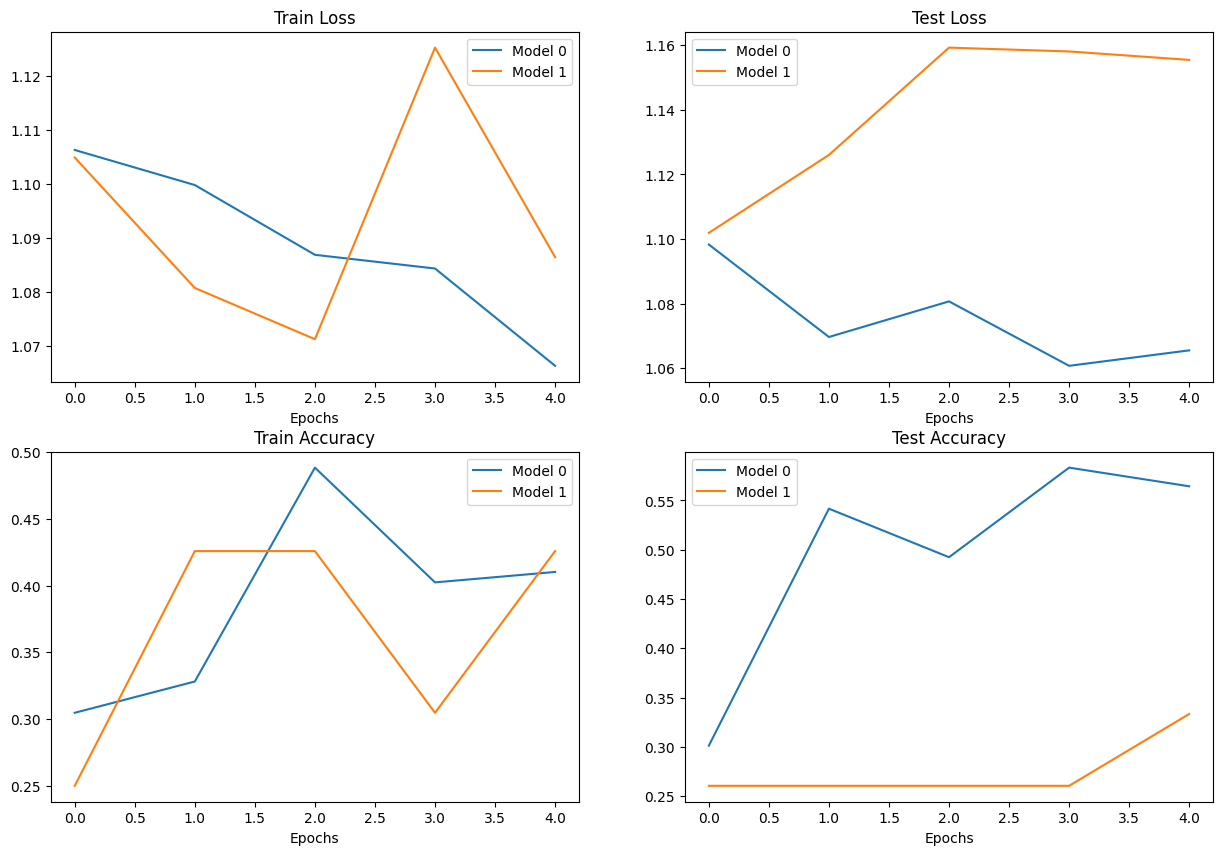

In [ ]:
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df['train_loss'], label='Model 0')
plt.plot(epochs, model_1_df['train_loss'], label='Model 1')
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df['test_loss'], label='Model 0')
plt.plot(epochs, model_1_df['test_loss'], label='Model 1')
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df['train_acc'], label='Model 0')
plt.plot(epochs, model_1_df['train_acc'], label='Model 1')
plt.title('Train Accuracy')
plt.xlabel('Epochs')
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df['test_acc'], label='Model 0')
plt.plot(epochs, model_1_df['test_acc'], label='Model 1')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.legend()

## 11. Making a prediction on a custom image

Test the models' prediction on a sample/image thats not in either train/test dataset

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / '04-pizza-dad.jpeg'

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path, 'wb') as f:
    # When downloading from GitHub, need to use the 'raw' file link
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg?raw=true')
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exist, skipping download...")


### 11.1 Loading in a custom image with PyTorch

Have to make sure custom image is in the same format as the data our model was trained on

* In tensor form with datatype (torch.float32)
* Of shape 64 x 64 x 3
* On the right device

In [ ]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

### 11.2 Making a prediction on a custom image with a trained PyTorch model

In [ ]:
# Load in the custom image and convert to torch.float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255

# Create transform pipeline to resize image
custom_image_transform = transforms.Compose([transforms.Resize(size=(64, 64))])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# We also need to added the batch size dimension to our custom image tensor in order for our model to make prediction on it
custom_image_transformed.unsqueeze(0).shape

torch.Size([1, 3, 64, 64])

In [ ]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))
custom_image_pred

tensor([[ 0.0670,  0.0538, -0.2040]])

*** Note, to make a prediction on a custom image we had to:***
* Load the image and turn it into a tensor
* Make sure image was the same datatype as the model (torch.float32)
* Make sure the image was the same shape as the data the model was trained on (3x64x64) with a batch size...(1, 3, 64, 64)
* Make sure the image was on the same device as our model

In [ ]:
# Convert logits -> prediction probabilities
custom_image_pred_probas = torch.softmax(custom_image_pred, dim=1)

# Convert prediction probabilities -> prediction labels
custom_image_pred_labels = torch.argmax(custom_image_pred_probas, dim=1)

class_names[custom_image_pred_labels]


'pizza'

### 11.3 Putting custom image prediction together: building a function


In [ ]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device=device):
  """Makes a prediction on a target image with a trained model and plots the image and prediction"""

  # Load in the image
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # Divide the image pixel values by 255 to get them between [0, 1]
  target_image = target_image / 255

  # Transform if necessary
  if transform:
    target_image = transform(target_image)

  # Make sure the model is on the target device
  model.to(device)

  # Turn on eval/inference mode and make prediction
  model.eval()
  with torch.inference_mode():
    # Add an extra dimension to the image, adding the batch dimension
    target_image = target_image.unsqueeze(0)

    target_image_pred = model(target_image.to(device)) # Make sure the target image is on the right device

  # Convert the logits
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # Convert to prediction labels
  target_image_pred_labels = torch.argmax(target_image_pred_probs, dim=1)

  # Plot the image alongside the prediction and prediction probability
  plt.imshow(target_image.squeeze().permute(1, 2, 0)) # remove batch dimension and rearrange shape to be (h, w, c)
  if class_names:
    title = f"Pred: {class_names[target_image_pred_labels.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  else:
    title = f"Pred: {target_image_pred_labels} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False)


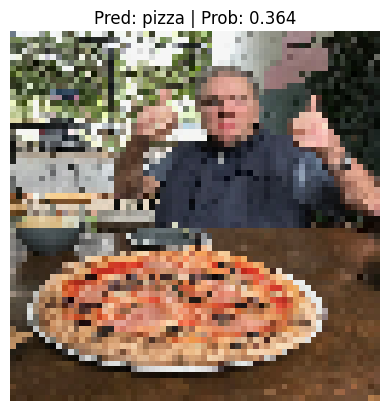

In [ ]:
# Pred on our custom image

pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)